In [ ]:
import nibabel as nib
import torch
from scipy import ndimage
import pydicom
import pandas as pd
from io import BytesIO
from google.colab import drive
import zipfile
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from tqdm import tqdm
from pydicom.data import get_testdata_file
from pydicom.uid import ImplicitVRLittleEndian

In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

In [ ]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def zero_pad_3d(array, target_shape):
    padded_array = np.zeros(target_shape)
    padded_array[:array.shape[0], :array.shape[1], :array.shape[2]] = array
    return padded_array

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

def resample(image, voxel_spacing, target_voxel_spacing = [2,2,2], target_grid_size=[164,164,164]):
    resize_factor = voxel_spacing/target_voxel_spacing
    resampled_image = ndimage.interpolation.zoom(image, resize_factor)
    return resampled_image

def center_crop_3d(image, crop_size):
    """
    Crops the 3D image to a fixed size in the z-dimension and center crops along x and y dimensions.

    Parameters:
    image (numpy array): Input 3D image with shape (depth, height, width)
    crop_size (tuple): Desired crop size in the form (crop_depth, crop_height, crop_width)

    Returns:
    numpy array: Cropped 3D image with specified crop_size
    """
    depth, height, width = image.shape

    # Calculate start and end indices for height (y) and width (x) for center cropping
    start_height = max(0, (height - crop_size[1]) // 2)
    start_width = max(0, (width - crop_size[2]) // 2)
    end_height = start_height + crop_size[1]
    end_width = start_width + crop_size[2]

    # Calculate start and end indices for depth (z) cropping
    start_depth = max(0, (depth - crop_size[0]) // 2)
    end_depth = start_depth + crop_size[0]

    # Perform cropping
    cropped_image = image[start_depth:end_depth, start_width:end_width, start_height:end_height]

    return cropped_image

## Downloading the MosMedData

In this demo preprocessing code, We use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted NIfTI files: ['study_0001.nii.gz', 'study_0002.nii.gz', 'study_0003.nii.gz', 'study_0004.nii.gz', 'study_0005.nii.gz', 'study_0006.nii.gz', 'study_0007.nii.gz', 'study_0008.nii.gz', 'study_0009.nii.gz', 'study_0010.nii.gz', 'study_0011.nii.gz', 'study_0012.nii.gz', 'study_0013.nii.gz', 'study_0014.nii.gz', 'study_0015.nii.gz', 'study_0016.nii.gz', 'study_0017.nii.gz', 'study_0018.nii.gz', 'study_0019.nii.gz', 'study_0020.nii.gz', 'study_0021.nii.gz', 'study_0022.nii.gz', 'study_0023.nii.gz', 'study_0024.nii.gz', 'study_0025.nii.gz', 'study_0026.nii.gz', 'study_0027.nii.gz', 'study_0028.nii.gz', 'study_0029.nii.gz', 'study_0030.nii.gz', 'study_0031.nii.gz', 'study_0032.nii.gz', 'study_0033.nii.gz', 'study_0034.nii.gz', 'study_0035.nii.gz', 'study_0036.nii.gz', 'study_0037.nii.gz', 'study_0038.nii.gz', 'study_0039.nii.gz', 'study_0040.nii.gz', 'study_

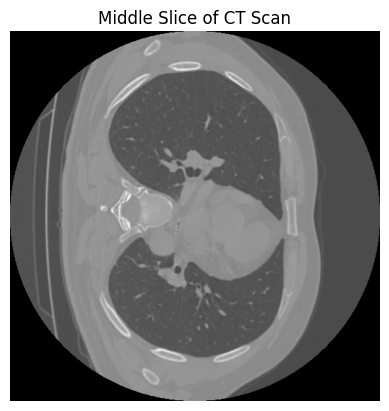

In [ ]:
#Mount Google Drive
drive.mount('/content/drive')

# Define paths (Modify this based on your Google Drive file structure)
zip_file_path = "/content/drive/My Drive/Sab Lab/Aim 4 Paper - 01/CT-0.zip"
extract_path = "/content/drive/My Drive/Sab Lab/Aim 4 Paper - 01/Extracted_data"

#Extract ZIP File
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
extract_path = os.path.join(extract_path, 'CT-0')

#List Extracted NIfTI Files
nii_files = [f for f in os.listdir(extract_path) if f.endswith('.nii') or f.endswith('.nii.gz')]
print("Extracted NIfTI files:", nii_files)

#Load and Display NIfTI File
if nii_files:
    nii_file_path = os.path.join(extract_path, nii_files[0])  # Load the first NIfTI file
    img = nib.load(nii_file_path)
    #Get voxel spacing from the affine matrix
    voxel_spacing_affine = img.header.get_zooms()  # (dx, dy, dz)
    print("Voxel Spacing (Affine):", voxel_spacing_affine)
    data = img.get_fdata()

    # Display the middle slice of the 3D CT scan
    plt.imshow(data[:, :, data.shape[2] // 2], cmap="gray")
    plt.axis("off")
    plt.title("Middle Slice of CT Scan")
    plt.show()
else:
    print("No NIfTI files found.")


In [ ]:
##Windowing
#Convert the dicom to housfield unit if its not converted
window_center = 0
window_width  = 2000
windowed_image = window_image(data,0,2000)

In [ ]:
##Resampling
voxel_spacing_affine=np.array(voxel_spacing_affine)
resampled_image=resample(windowed_image, voxel_spacing_affine)
resampled_image.shape

[0.34 0.34 4.  ]


<ipython-input-49-b9f3f8c2329a>:25: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  resampled_image = ndimage.interpolation.zoom(image, resize_factor)


(174, 174, 172)

In [ ]:
##Cropping
crop_size=(164,164,164)
cropped_image=center_crop_3d(resampled_image,crop_size)
cropped_image.shape

(164, 164, 164)

In [ ]:
##Padding
output=zero_pad_3d(cropped_image,crop_size)

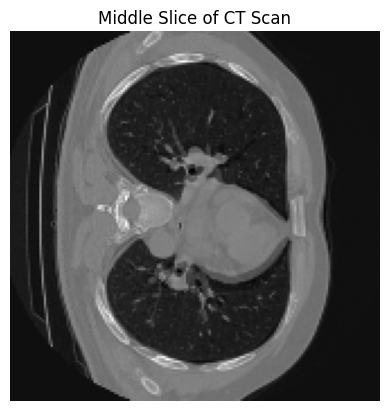

In [ ]:
# Display the middle slice of the Processed 3D CT scan
plt.imshow(output[:, :, output.shape[2] // 2], cmap="gray")
plt.axis("off")
plt.title("Middle Slice of CT Scan")
plt.show()